# **ALESSANDRO MACCARIO**
# Matriculation number: **12116666**
# COURSE OF: LABOR "FUNDAMENTAL IMAGE PROCESSING"
### Professor Perumadura Meluka Nadeesh De Silva, M.Sc.
### Professor Dr. Vahid Tavakkoli, MSc.

# **DOCUMENT-SCANNER PROJECT USING OPENCV**





---



---



In [ ]:
# load the required libraries
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

# WHY RESIZE IT?
In generally it is better to decrease the size of an image rather than increasing (exceptions do apply, of course). By decreasing the image size, we have fewer pixels to process (not to mention less “noise” to deal with), which leads to faster and more accurate image processing algorithms.

So, in order to speedup image processing, as well as make our edge detection step more accurate, we resize our scanned image.

In [ ]:
# set parameters for figure size dynamically in matplotlib 
plt.rcParams['figure.figsize'] = [16,10]

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it

# FIRST IMAGE
image = cv2.imread('receipt_1.JPG')

# # SECOND IMAGE
# image2 = cv2.imread('receipt-edge-detected.jpg')

# # THIRD IMAGE
# image3 = cv2.imread('scan_test.jpg')

# We keep track of the ratio because we'll resize our image based on that later.
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height=500)

We convert the image from RGB to grayscale and perform Gaussian blurring to remove high frequency noise (aiding in contour detection in the next step), and perform Canny edge detection.

# WHY GRAYSCALE?
For other algorithms to work: many algorithms are customized to work only on grayscale images (e.g. Canny edge detection function pre-implemented in OpenCV library works on Grayscale images only).

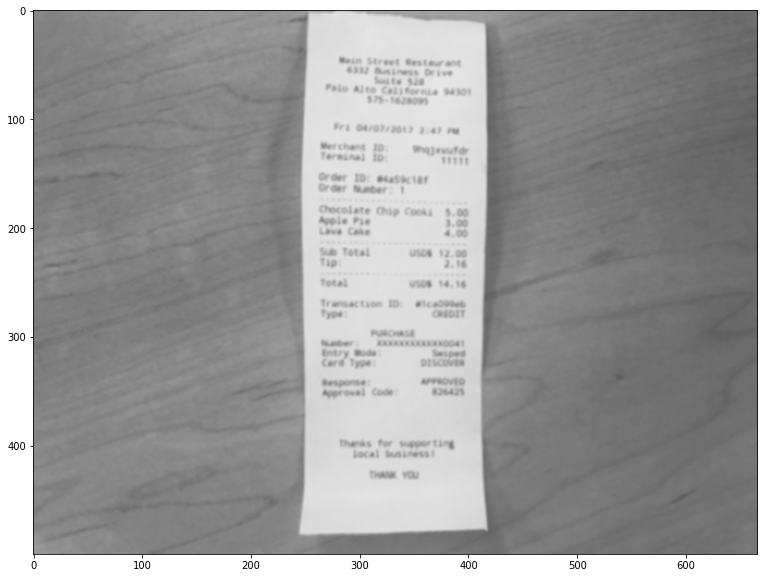

In [ ]:
# convert the image to grayscale, blur it, and find edges
# in the image

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)

# Show the image
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)

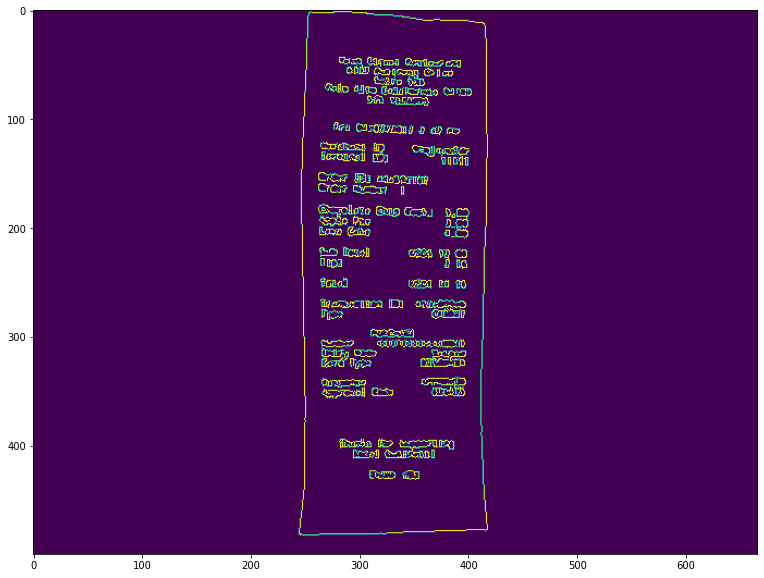

In [ ]:
# apply the Canny Algorithm with min and max values to
edged = cv2.Canny(gray, 75, 200) # minVal, maxVal

# Check the image
plt.imshow(edged)

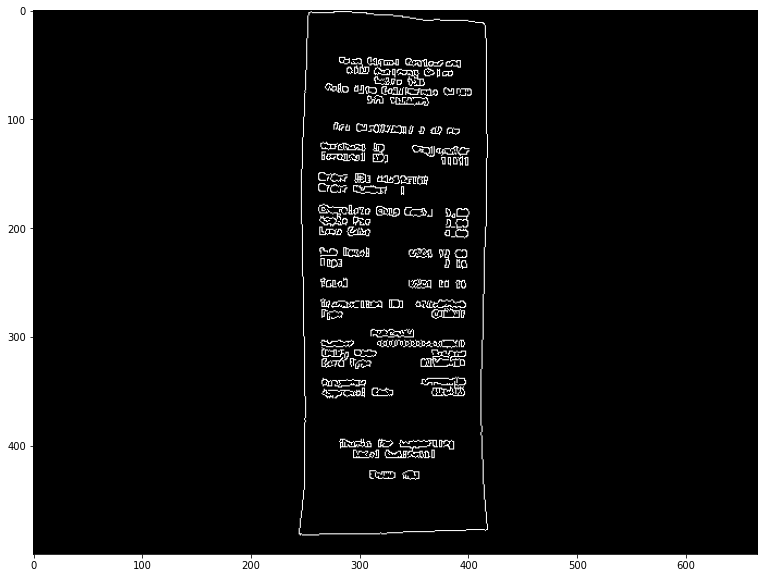

In [ ]:
  # Use cv2.cvtColor() method to convert an image from one color space to another
  dispImage = cv2.cvtColor(edged.copy(), cv2.COLOR_GRAY2RGB)
  plt.imshow(dispImage)

Now, we find the contours in the edged image, keeping only the largest four, and initialize the screen contour.

There are three arguments in cv.findContours() function: 
first one is the source image, the second is the contour retrieval mode (RETR_TREE: retrieves all of the contours and reconstructs a full hierarchy of nested contours) and the third is the contour approximation method.
The outputs is the contours and hierarchy.
Contours is a Python list of all the contours in the image.
Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

In [ ]:
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:4]

In [ ]:
for c in contours:
    perimeter = cv2.arcLength(c, True) # (curve, closed = True/False)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    
    # if our approximated contour has four points
    # (read the result as anti-clockwise, starting to the top-left)
    if len(approx) == 4:
        screenContour = approx
        print(screenContour)
        break

[[[255   1]]

 [[244 481]]

 [[415 478]]

 [[415  14]]]


Now we draw contours based on screenContour that contains the four contours for the main object of the image.

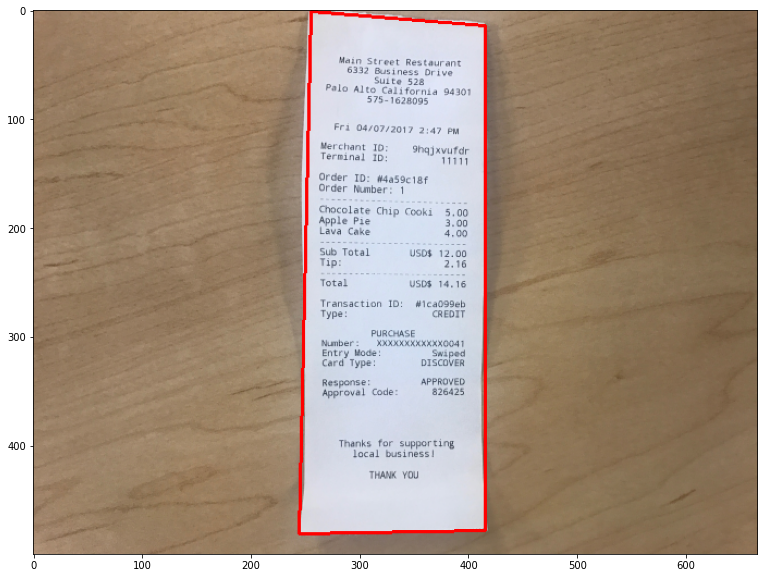

In [ ]:
cv2.drawContours(image, [screenContour], -1, (0,0,255), 2) # -1 => draw all contours, (color), thickness
dispImage = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
plt.imshow(dispImage)

In order to calculate the Euclidean Distance in the Four-Points-Transformations we need to order the four points of the document.
That's because it will be simpler to create the _rect_ matrix composed by the new coordinates already ordered.

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    # the top-left point will have the smallest sum, 
    # whereas the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    print(s)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # the top-right point will have the smallest difference, 
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

The image variable is the image we want to apply the perspective transform to. 
And the _pts_ list is the list of four points that contain the ROI (Region of Interests = an area of an image defined for further analysis or processing) of the image we want to transform.

To notice how the points are now stored in an imposed order: top-left, top-right, bottom-right, and bottom-left. 
Keeping a consistent order is important when we apply our _perspective transformation_.

In [ ]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them individually
    rect = order_points(pts)
    
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the maximum distance 
    # between bottom-right and bottom-left x-coordiates or the top-right 
    # and top-left x-coordinates.
    # This is because we are approximating the distance and we have to find
    # the maximum value of width.

    # Calculate the Euclidean Distance
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the maximum distance 
    # between the top-right and bottom-right y-coordinates or the top-left 
    # and bottom-left y-coordinates.
    # Again, this is because we are approximating the distance and we have to find
    # the maximum value of width.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Here, we define 4 points representing our “top-down” view of the image. 
    # The first entry in the list is (0, 0) indicating the top-left corner. 
    # The second entry is (maxWidth - 1, 0) which corresponds to the top-right
    # corner. Then we have (maxWidth - 1, maxHeight - 1) which is the 
    # bottom-right corner. Finally, we have (0, maxHeight - 1) which is the 
    # bottom-left corner.
    # Here these points are defined in a consistent ordering representation 
    # — and will allow us to obtain the top-down view of the image.

    destinationPoints = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype = "float32")
    print(destinationPoints)

    # Now compute the perspective transform matrix: apply the transformation 
    # matrix to obtain the new and correct one, transformed.
    # To actually obtain the top-down, “birds eye view” of the image we’ll
    # utilize the cv2.getPerspectiveTransform function. 
    # This function requires two arguments, rect, which is the list of 4 
    # ROI points in the original image, and dst, which is our list of 
    # transformed points. The cv2.getPerspectiveTransform function returns M, 
    # which is the actual transformation matrix.

    mapped = cv2.getPerspectiveTransform(rect, destinationPoints)

    # We apply the transformation matrix using the cv2.warpPerspective
    # function. We pass in the image, our transform matrix M, along with the 
    # width and height of our output image. 
    # The output of cv2.warpPerspective is our warped image, 
    # which is our top-down view.
    warped = cv2.warpPerspective(image, mapped, (maxWidth, maxHeight))
    
    return warped

In [ ]:
# apply the four point transform to obtain a top-down view of the original image
warped = four_point_transform(orig, screenContour.reshape(4, 2) * ratio)

# and show the image
plt.imshow(warped)

[1548.288 4384.8   5400.864 2594.592]
[[   0.    0.]
 [1033.    0.]
 [1033. 2902.]
 [   0. 2902.]]


Convert the warped image to grayscale, then threshold it to give it the 'black and white' paper effect.
The thresholding tecnique is used for converting the image to binary so it is possible to separate the background from the foreground more easily.

Create a threshold: if there's uneven background illumination adaptive _thresholding threshold_local()_ (a.k.a. local thresholding) may produce better results.


In [ ]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")

warped = (warped > T).astype("uint8") * 255

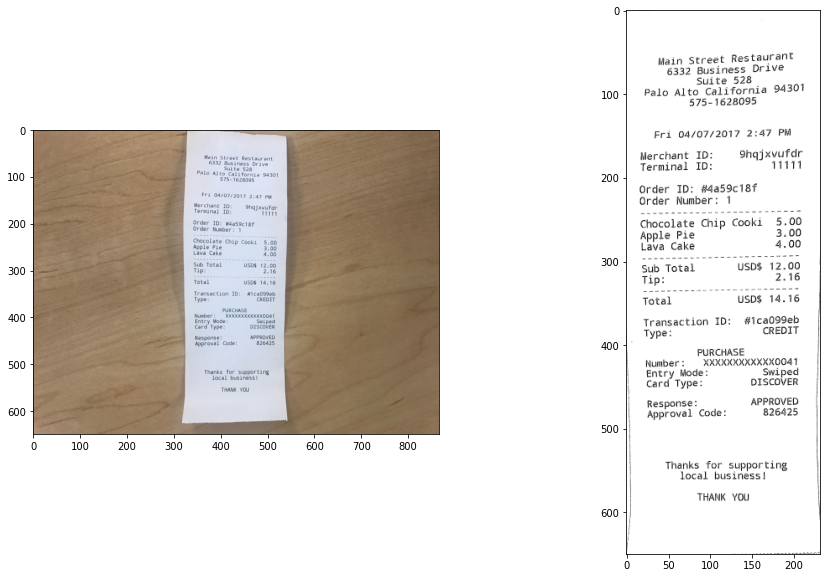

In [ ]:
# resizing the image
origImage = imutils.resize(orig, height = 650)
dispImage = imutils.resize(warped, height = 650)

dispImage = cv2.cvtColor(dispImage, cv2.COLOR_GRAY2RGB)
origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2RGB)

# Plotting the original and the final image
plt.subplot(1, 2, 1)
plt.imshow(origImage)
plt.subplot(1, 2, 2)
plt.imshow(dispImage)
plt.show()